<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Food-101-Classification-Challenge" data-toc-modified-id="Food-101-Classification-Challenge-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Food-101 Classification Challenge</a></span><ul class="toc-item"><li><span><a href="#Dataset" data-toc-modified-id="Dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Dataset</a></span><ul class="toc-item"><li><span><a href="#Difficulty" data-toc-modified-id="Difficulty-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Difficulty</a></span></li></ul></li><li><span><a href="#SoTA-Top-1-Accuracy" data-toc-modified-id="SoTA-Top-1-Accuracy-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>SoTA Top-1 Accuracy</a></span></li><li><span><a href="#Baseline-model" data-toc-modified-id="Baseline-model-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Baseline model</a></span></li><li><span><a href="#Progressive-Resizing" data-toc-modified-id="Progressive-Resizing-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Progressive Resizing</a></span></li><li><span><a href="#Test-Time-Augmentation" data-toc-modified-id="Test-Time-Augmentation-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Test Time Augmentation</a></span></li><li><span><a href="#Mixup" data-toc-modified-id="Mixup-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Mixup</a></span></li><li><span><a href="#Progressive-Resizing-+-MixUp" data-toc-modified-id="Progressive-Resizing-+-MixUp-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Progressive Resizing + MixUp</a></span></li><li><span><a href="#Label-Smoothing" data-toc-modified-id="Label-Smoothing-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Label Smoothing</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

# Food-101 Classification Challenge

## Dataset

Food-101 dataset contains 101 categories of food and 101,000 total images. There are 750 train images and 250 test images per each category.  
The size of each image varies, but the maximum side length is 512 pixel for all images.

I created a smaller subset of data for efficient training process. The tinyset consist of 10 manually selected categories with 100 training images and original 250 test images per category.  
I deliberately chose to use the test dataset as a validation set to increase the model's performance. In many cases, the ratio of the training, validation and test dataset is 80:10:10. I thought using only 75% of data for both training and validation may not be effective.

In [3]:
from fastai2.vision.all import *

In [9]:
path = Path('../data/food-101-tinyset-10-100')
Path.BASE_PATH = path
path.ls()

(#3) [Path('valid'),Path('.DS_Store'),Path('train')]

There are 10 categories * (100 train + 250 test) = 3500 images.

In [10]:
files = get_image_files(path)
len(files)

3500

The following `get_dls` function returns dataloader for designate batch_size and batch transform image size. I chose 460 pixel as the size for `Resize` method because it's in between 384 and 512 pixels. `Resize` is changing the entire dataset to one size to be fed into GPU. `RandomResizedCrop` is randomely cropping some part of an image and resizing, and it's implemented as `aug_transforms` parameter.
I'm using both `RandomResizedCrop` and `Resize` as default data augmentation method throughout the training. 

In [13]:
def get_dls(batch_size, img_size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       get_items=get_image_files,
                       get_y=parent_label,
                       splitter=GrandparentSplitter(),
                       item_tfms=Resize(460),
                       batch_tfms=aug_transforms(size=img_size, min_scale=0.75))
    return dblock.dataloaders(path, bs=batch_size)

In [14]:
dls = get_dls(128, 224)

### Difficulty

As you can see below, not every image is having perfect brightness and sharpness. The first steak image is too blurry that it's hard to guess without taking a closer look. Also, the training set includes noises since some training images are deliberately mislabeled.

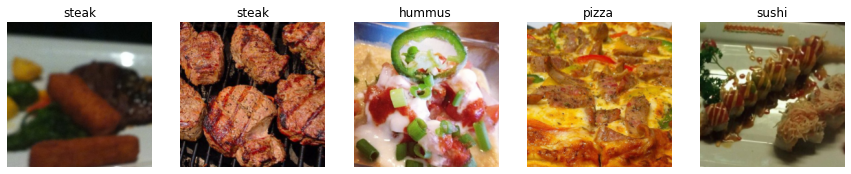

In [35]:
dls.show_batch(nrows=1, ncols=5)

There are some mislabeled or iffy images. For example, the following image is labeled 'donuts' but technically it doesn't contain food donut. 

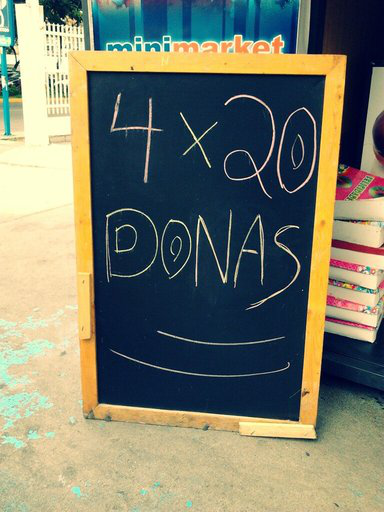

In [30]:
load_image(Path('../data/food-101-tinyset-10-100/train/donuts/1452592.jpg'))

And the following image is labeled `sashimi` but it's definitely not sashimi.

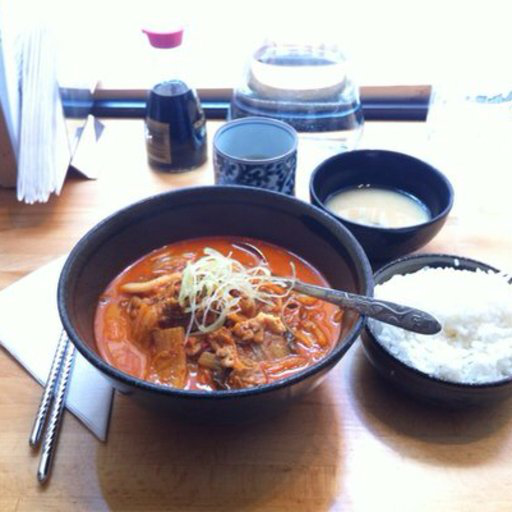

In [31]:
load_image(Path('../data/food-101/train/sashimi/3564342.jpg'))

## SoTA Top-1 Accuracy

The current state of the art Top-1 Accuracy is <b>93%</b> using [EfficientNet-B7](https://arxiv.org/pdf/1905.11946v3.pdf). Since I used resnet50, my benchmark was <b>90.52%</b> from this article [Platform.ai](https://platform.ai/blog/page/3/new-food-101-sota-with-fastai-and-platform-ais-fast-augmentation-search/) using resnet50. 

I used Fastai2 for this challenge for fast iteration. My next goal is to implement this process in PyTorch using EfficientNet.

## Baseline model

First of all, I'm going to start with a baseline model with resnet50. I chose `cnn_learner` because it uses transfer learning from ImageNet dataset and normalizes data with statistics from ImageNet dataset. `fine_tune` trains the last layer of pretrained weights with our food dataset when the rest of the layers are frozen, and then unfreezes them and trains the entire layers altogether. 

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=accuracy)
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,2.715778,1.089172,0.656000,00:23


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


epoch,train_loss,valid_loss,accuracy,time
0,1.046330,0.706843,0.769200,00:23
1,0.816567,0.644759,0.797600,00:22
2,0.648835,0.607758,0.826400,00:22
3,0.519941,0.574507,0.835200,00:22
4,0.435676,0.565177,0.836400,00:22


The baseline model has top-1 accuracy of 0.836.

## Progressive Resizing

Progressive Resizing is to start training from small images and gradually using larger images over time during the training process. Since most of the training is done with small images, it can fasten the training process. The large images used in later epochs help increase the accuracy with high resolution.  
I started from the image size of 128 and increased it to 256 and ended with 512. Make sure to decrease batch size as you increase the image size.

In [10]:
dls = get_dls(128, 128)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [16]:
learn = cnn_learner(dls, resnet50, metrics=accuracy)

I ran an experiment to find a good learning rate and chose 1e-3 as a good max learning rate for the training.

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


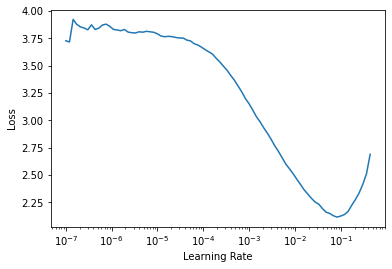

In [ ]:
lr_min, lr_steep = learn.lr_find()

In [17]:
learn.fit_one_cycle(n_epoch=3, lr_max=1e-3 )

epoch,train_loss,valid_loss,accuracy,time
0,3.080187,1.552444,0.516000,00:23
1,2.209398,1.134174,0.676800,00:23
2,1.774893,1.098683,0.684400,00:23


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [18]:
learn.dls = get_dls(64, 256)
learn.fine_tune(epochs=5, base_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.091424,1.341987,0.637600,00:25


epoch,train_loss,valid_loss,accuracy,time
0,0.582805,0.798702,0.782800,00:26
1,0.482059,0.809196,0.799200,00:25
2,0.369935,0.621558,0.837600,00:25
3,0.290372,0.545756,0.854000,00:25
4,0.220459,0.512104,0.858000,00:25


In [19]:
learn.dls = get_dls(32, 512)
learn.fine_tune(epochs=5, base_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.480798,0.598602,0.838400,00:44


epoch,train_loss,valid_loss,accuracy,time
0,0.342324,0.623538,0.836800,00:48
1,0.425557,0.758767,0.818000,00:47
2,0.430057,0.603737,0.851200,00:47
3,0.335620,0.455539,0.870800,00:47
4,0.221802,0.425487,0.880400,00:47


The best top-1 accuracy is 0.88 using progressive resizing trained over 15 epochs.

## Test Time Augmentation

Test Time Augmentation is generating various versions of augmentated images during inference or validation and then taking the average or maximum of the predictions for the augmentated versions of each image.

TTA can help increase the accuracy by featuring different parts of each image during inference.  
I used averaging the 4 predictions from the augmentations and got 0.888 top-1 accuracy. There was a slight bump (0.008) in the accuracy using TTA.  
For training the full dataset, I used averaging 8 predictions from the augmentation to increase the accuracy!

In [21]:
preds, targets = learn.tta()
accuracy(preds, targets).item()

0.8888000249862671

## Mixup

Mixup is another data augmentation method which takes weighted average of two images as feature and the weighted average of the two labels as target. To be able to use this method, targets must be one-hot encoded but it can be easily implemented using fastai library.

In [33]:
dls = get_dls(128, 224)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [34]:
learn = cnn_learner(dls, resnet50, metrics=accuracy, cbs=MixUp)

In [35]:
learn.fit_one_cycle(50, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.469340,2.176691,0.291600,00:25
1,2.940089,1.222296,0.590000,00:25
2,2.573244,0.848735,0.725600,00:25
3,2.363140,0.707555,0.779600,00:25
4,2.197926,0.687860,0.794400,00:25
5,2.029866,0.676326,0.798400,00:25
6,1.909922,0.672667,0.800800,00:25
7,1.796196,0.671901,0.785200,00:25
8,1.682706,0.634375,0.809200,00:25
9,1.600546,0.608318,0.819600,00:25


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Training with Mixup for 50 epochs achieved 0.879 top-1 accuracy. It's almost the same as top-1 accuracy from progressive resizing (0.88).

## Progressive Resizing + MixUp

I'm going to apply both progresive resizing and mixup to see how far it can go.

In [10]:
dls = get_dls(128, 128)
learn = cnn_learner(dls, resnet50, metrics=accuracy, cbs=MixUp)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


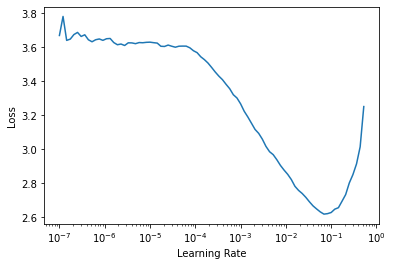

In [11]:
lr_min, lr_steep = learn.lr_find()

In [12]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.287628,1.587026,0.531200,03:29
1,2.727668,1.146409,0.661200,00:19
2,2.424182,1.118782,0.662000,00:19


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [13]:
learn.dls = get_dls(64, 256)
learn.fine_tune(20, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.951339,1.530842,0.574800,00:22


epoch,train_loss,valid_loss,accuracy,time
0,1.657361,0.863195,0.736400,00:22
1,1.522937,0.618937,0.805200,00:22
2,1.403381,0.614135,0.811200,00:22
3,1.328454,0.601913,0.814000,00:22
4,1.273837,0.657138,0.809200,00:22
5,1.232877,0.648867,0.808400,00:22
6,1.191166,0.555043,0.833200,00:22
7,1.157918,0.703500,0.803200,00:22
8,1.111307,0.508345,0.843200,00:22
9,1.067694,0.463959,0.858400,00:22


In [16]:
learn.dls = get_dls(32, 512)
learn.fine_tune(20, 3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.904702,0.448206,0.865600,00:40


epoch,train_loss,valid_loss,accuracy,time
0,0.867237,0.428388,0.873600,00:46
1,0.851680,0.397655,0.882800,00:46
2,0.832988,0.390529,0.884400,00:46
3,0.833968,0.381219,0.886800,00:46
4,0.823618,0.363985,0.894400,00:46
5,0.816551,0.361954,0.896000,00:46
6,0.806904,0.361130,0.901200,00:46
7,0.799596,0.355909,0.894400,00:46
8,0.782851,0.363236,0.896800,00:46
9,0.798630,0.369338,0.889600,00:46


With progressive resizing and mixup, the top-1 accuracy is 0.905. This is slightly better than just using one of them.

In [17]:
preds, targets = learn.tta()
accuracy(preds, targets).item()

0.9056000113487244

## Label Smoothing

The last method I'm going to try is `Label Smoothing`. Label smoothing is under the circumstance of one-hot encoded targets, changing all the 0 targets to something slightly bigger than 0 and all the 1 targets to something slightly smaller than 1. This prevents overfitting by making the model less confident when the dataset has mislabeled images.

In [12]:
dls = get_dls(128, 224)

In [13]:
learn = cnn_learner(dls, resnet50, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [14]:
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.240028,1.792015,0.427600,09:19
1,2.550504,1.350038,0.724000,00:21
2,2.137749,1.425201,0.798400,00:21
3,1.872374,1.368508,0.801200,00:21
4,1.679462,1.330092,0.785200,00:21
5,1.533470,1.245660,0.803200,00:21
6,1.417221,1.182229,0.797200,00:21
7,1.315613,1.120850,0.811200,00:21
8,1.238598,1.091487,0.813600,00:21
9,1.164580,1.061319,0.816800,00:21


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Applying label smoothing achieved 0.844 top-1 accuracy. Label smoothing can be more effective if it's combined with progressive resizing. I'll apply different combinations of the methods with the full dataset.

# Conclusion

Progressive resizing has significantly increased the accuracy compared to the baseline model. Test Time Augmentation can be applied to boost the accuracy even more. Both Mixup and Label Smoothing did increase the accuracy but it took longer to train to get comparable accuracy. Progressive resizing can be applied with Mixup or Label Smoothing to increase the accuracy with longer epochs.